In [4]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import log, factorial
from scipy.optimize import minimize

In [245]:
## redo of question 1

In [249]:
train_data = pd.read_csv('/Users/giovannimaya/Downloads/data/PCC_study_train.csv')
vaccinated_train_data = train_data[train_data['vax_status'] == 'Vaccinated']
unvaccinated_train_data = train_data[train_data['vax_status'] == 'Unvaccinated']

vax_cond_probs = vaccinated_train_data.groupby(
    ['WBscore', 'PCCsymp']).size() / len(vaccinated_train_data)
unvax_cond_probs = unvaccinated_train_data.groupby(
    ['WBscore', 'PCCsymp']).size() / len(unvaccinated_train_data)

vax_cond_probs_table = vax_cond_probs.unstack().fillna(0)  # Fill N/A with 0s
unvax_cond_probs_table = unvax_cond_probs.unstack().fillna(0)

print("Conditional Probabilities for Vaccinated Patients:")
print(vax_cond_probs_table)
print("\nConditional Probabilities for Unvaccinated Patients:")
print(unvax_cond_probs_table)

Conditional Probabilities for Vaccinated Patients:
PCCsymp        Less      More      Same
WBscore                                
Improved   0.750000  0.000000  0.027778
Unchanged  0.083333  0.027778  0.027778
Worsened   0.027778  0.027778  0.027778

Conditional Probabilities for Unvaccinated Patients:
PCCsymp        Less      More      Same
WBscore                                
Improved   0.076923  0.025641  0.076923
Unchanged  0.128205  0.102564  0.282051
Worsened   0.000000  0.153846  0.153846


In [312]:
train_data = pd.read_csv(
    '/Users/giovannimaya/Downloads/data/PCC_study_train.csv')
train_data = train_data.drop(columns='Unnamed: 0')
train_data

,vax_status,WBscore,PCCsymp
0,Vaccinated,Improved,Less
1,Vaccinated,Unchanged,Less
2,Vaccinated,Improved,Less
3,Vaccinated,Worsened,Less
4,Vaccinated,Worsened,More
...,...,...,...
70,Unvaccinated,Unchanged,Less
71,Unvaccinated,Worsened,Same
72,Unvaccinated,Improved,Same
73,Unvaccinated,Unchanged,More


In [313]:
train_data_pivot = pd.pivot_table(train_data,
                                index=['WBscore', 'PCCsymp'],
                                columns='vax_status',
                                aggfunc='size',
                                fill_value=0)
train_data_pivot

vax_status         Unvaccinated  Vaccinated
WBscore   PCCsymp                          
Improved  Less                3          27
          More                1           0
          Same                3           1
Unchanged Less                5           3
          More                4           1
          Same               11           1
Worsened  Less                0           1
          More                6           1
          Same                6           1

In [315]:
total_num_yes = (train_data['vax_status'] == 'Vaccinated').sum()
total_num_no = (train_data['vax_status'] == 'Unvaccinated').sum()

class_prob_yes = total_num_yes / (total_num_yes + total_num_no)
class_prob_no = 1 - class_prob_yes
class_prob_yes, class_prob_no

(0.48, 0.52)

In [316]:
train_data_pivot_conds = train_data_pivot.copy()

train_data_pivot_conds['Vaccinated'] /= total_num_yes

train_data_pivot_conds['Unvaccinated'] /= total_num_no

train_data_pivot_conds

vax_status         Unvaccinated  Vaccinated
WBscore   PCCsymp                          
Improved  Less         0.076923    0.750000
          More         0.025641    0.000000
          Same         0.076923    0.027778
Unchanged Less         0.128205    0.083333
          More         0.102564    0.027778
          Same         0.282051    0.027778
Worsened  Less         0.000000    0.027778
          More         0.153846    0.027778
          Same         0.153846    0.027778

In [352]:
test_case1 = ['Improved']
test_case2 = ['Less']

f_y, f_n = class_prob_yes, class_prob_no

for index in range(len(test_case1)):
    f_y *= train_data_pivot_conds['Vaccinated'].loc[(
        test_case1[index], test_case2[index])]
    f_n *= train_data_pivot_conds['Unvaccinated'].loc[(test_case1[index], test_case2[index])]

    # final_train.loc[(test_case[1], test_case[0]), 'Vaccinated']

p_y = f_y / (f_y + f_n)
p_n = f_n / (f_y + f_n)


print('P(Sleep Deprived = Yes | symptoms) = %.2f' % (p_y))
print('Odds in favor of Yes: %.2f' % (p_y / p_n))

if p_y > p_n:
    print('Prediction: Yes')
else:
    print('Prediction: No')

P(Sleep Deprived = Yes | symptoms) = 0.90
Odds in favor of Yes: 9.00
Prediction: Yes


In [290]:
def calculate_likelihood(outcomes, cond_probs_table, class_prob):
    likelihood = class_prob
    for outcome in outcomes:
        wb_score = outcome['WBscore']
        pcc_symp = outcome['PCCsymp']
        if wb_score in cond_probs_table.index and pcc_symp in cond_probs_table.columns:
            likelihood *= cond_probs_table.loc[wb_score, pcc_symp]
        else:
            likelihood *= 0
        return likelihood
            

In [292]:
example_outcome = [{'WBscore': 'Improved', 'PCCsymp': 'Same'}]
prob_vaccinated = len(vaccinated_train_data) / len(train_data)
prob_unvaccinated = len(unvaccinated_train_data) / len(train_data)

likelihood_vaccinated = calculate_likelihood(
    example_outcome, vax_cond_probs_table, prob_vaccinated)
likelihood_unvaccinated = calculate_likelihood(
    example_outcome, unvax_cond_probs_table, prob_unvaccinated)

print(f"Likelihood vaccinated: {likelihood_vaccinated}")
print(f"Likelihood unvaccinated: {likelihood_unvaccinated}")

Likelihood vaccinated: 0.013333333333333332
Likelihood unvaccinated: 0.04


In [297]:
predicted_data = pd.read_csv('/Users/giovannimaya/Downloads/data/PCC_study_test.csv')

def predict_vax_status_from_df(row, vax_probs_df, unvax_probs_df, prob_vax, prob_unvax):
    outcome = [{'WBscore': row['WBscore'], 'PCCsymp': row['PCCsymp']}]
    likelihood_vax = calculate_likelihood(
        outcome, vax_probs_df, prob_vax)
    likelihood_unvax = calculate_likelihood(
        outcome, unvax_probs_df, prob_unvax)
    return 'Vaccinated' if likelihood_vax > likelihood_unvax else 'Unvaccinated'


predicted_data['predicted_vax_status'] = predicted_data.apply(
    predict_vax_status_from_df,
    args=(vax_cond_probs_table, unvax_cond_probs_table,
          prob_vaccinated, prob_unvaccinated),
    axis=1
)
predicted_data

,Unnamed: 0,vax_status,WBscore,PCCsymp,predicted_vax_status
0,1,Vaccinated,Improved,Less,Vaccinated
1,2,Vaccinated,Improved,Less,Vaccinated
2,3,Vaccinated,Improved,Less,Vaccinated
3,4,Vaccinated,Worsened,Less,Vaccinated
4,5,Vaccinated,Unchanged,Less,Unvaccinated
5,6,Vaccinated,Improved,Less,Vaccinated
6,7,Vaccinated,Improved,Less,Vaccinated
7,8,Vaccinated,Improved,Less,Vaccinated
8,9,Vaccinated,Unchanged,More,Unvaccinated
9,10,Vaccinated,Improved,Less,Vaccinated


In [305]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB

train_data = pd.read_csv('/Users/giovannimaya/Downloads/data/PCC_study_train.csv')
test_data = pd.read_csv(
    '/Users/giovannimaya/Downloads/data/PCC_study_test.csv')

le_WBscore = LabelEncoder()
le_PCCsymp = LabelEncoder()
le_vax_status = LabelEncoder()

train_data['WBscore_encoded'] = le_WBscore.fit_transform(train_data['WBscore'])
train_data['PCCsymp_encoded'] = le_PCCsymp.fit_transform(train_data['PCCsymp'])
train_data['vax_status_encoded'] = le_vax_status.fit_transform(
    train_data['vax_status'])

test_data['WBscore_encoded'] = le_WBscore.transform(test_data['WBscore'])
test_data['PCCsymp_encoded'] = le_PCCsymp.transform(test_data['PCCsymp'])

X_train = train_data[['WBscore_encoded', 'PCCsymp_encoded']]
y_train = train_data['vax_status_encoded']

cnb_classifier = CategoricalNB()
cnb_classifier.fit(X_train, y_train)

X_test = test_data[['WBscore_encoded', 'PCCsymp_encoded']]

cnb_predictions_encoded = cnb_classifier.predict(X_test)

test_data['cnb_predicted_vax_status'] = le_vax_status.inverse_transform(
    cnb_predictions_encoded)

test_data[['WBscore', 'PCCsymp', 'cnb_predicted_vax_status']]

,WBscore,PCCsymp,cnb_predicted_vax_status
0,Improved,Less,Vaccinated
1,Improved,Less,Vaccinated
2,Improved,Less,Vaccinated
3,Worsened,Less,Vaccinated
4,Unchanged,Less,Vaccinated
5,Improved,Less,Vaccinated
6,Improved,Less,Vaccinated
7,Improved,Less,Vaccinated
8,Unchanged,More,Unvaccinated
9,Improved,Less,Vaccinated


In [ ]:
## end of redo q1

In [246]:
iris_df = pd.read_csv("/Users/giovannimaya/Downloads/data/iris.csv")
iris_df = iris_df.drop(columns=['rownames'])
iris_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [158]:
from 
X_train, X_test, y_train, y_test = train_test_split(
    iris_df.drop('Species', axis=1), iris_df['Species'], test_size=0.3, random_state=42, stratify=iris_df['Species'])
train_data = X_train.copy()
train_data['Species'] = y_train
train_data.shape

(105, 5)

/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


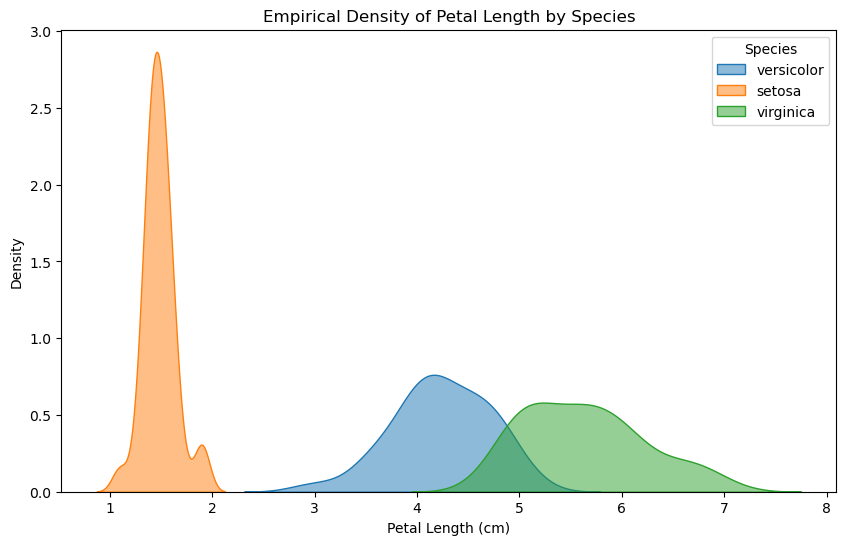

In [159]:
# Alternative approach to plot the empirical density of petal length for each species
plt.figure(figsize=(10, 6))

# Plot each species' petal length density separately to avoid any potential issues
for species in train_data['Species'].unique():
    subset = train_data[train_data['Species'] == species]
    sns.kdeplot(subset['Petal.Length'], label=species, fill=True, alpha=0.5)

plt.title('Empirical Density of Petal Length by Species')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Density')
plt.legend(title='Species')
plt.show()

In [161]:
petal_length_stats = train_data.groupby('Species')['Petal.Length'].agg([
    'mean', 'std']).reset_index()

petal_length_stats

,Species,mean,std
0,setosa,1.485714,0.153667
1,versicolor,4.237143,0.466581
2,virginica,5.631429,0.576384


In [162]:
from scipy.stats import norm

petal_length_to_classify = 4.31

likelihoods = {
    species: norm.pdf(petal_length_to_classify,
                      loc=row['mean'], scale=row['std'])
    for species, row in petal_length_stats.set_index('Species').iterrows()
}

likelihoods

{'setosa': 1.1542161536898683e-73,
 'versicolor': 0.8446730137297308,
 'virginica': 0.04998625890120865}

/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

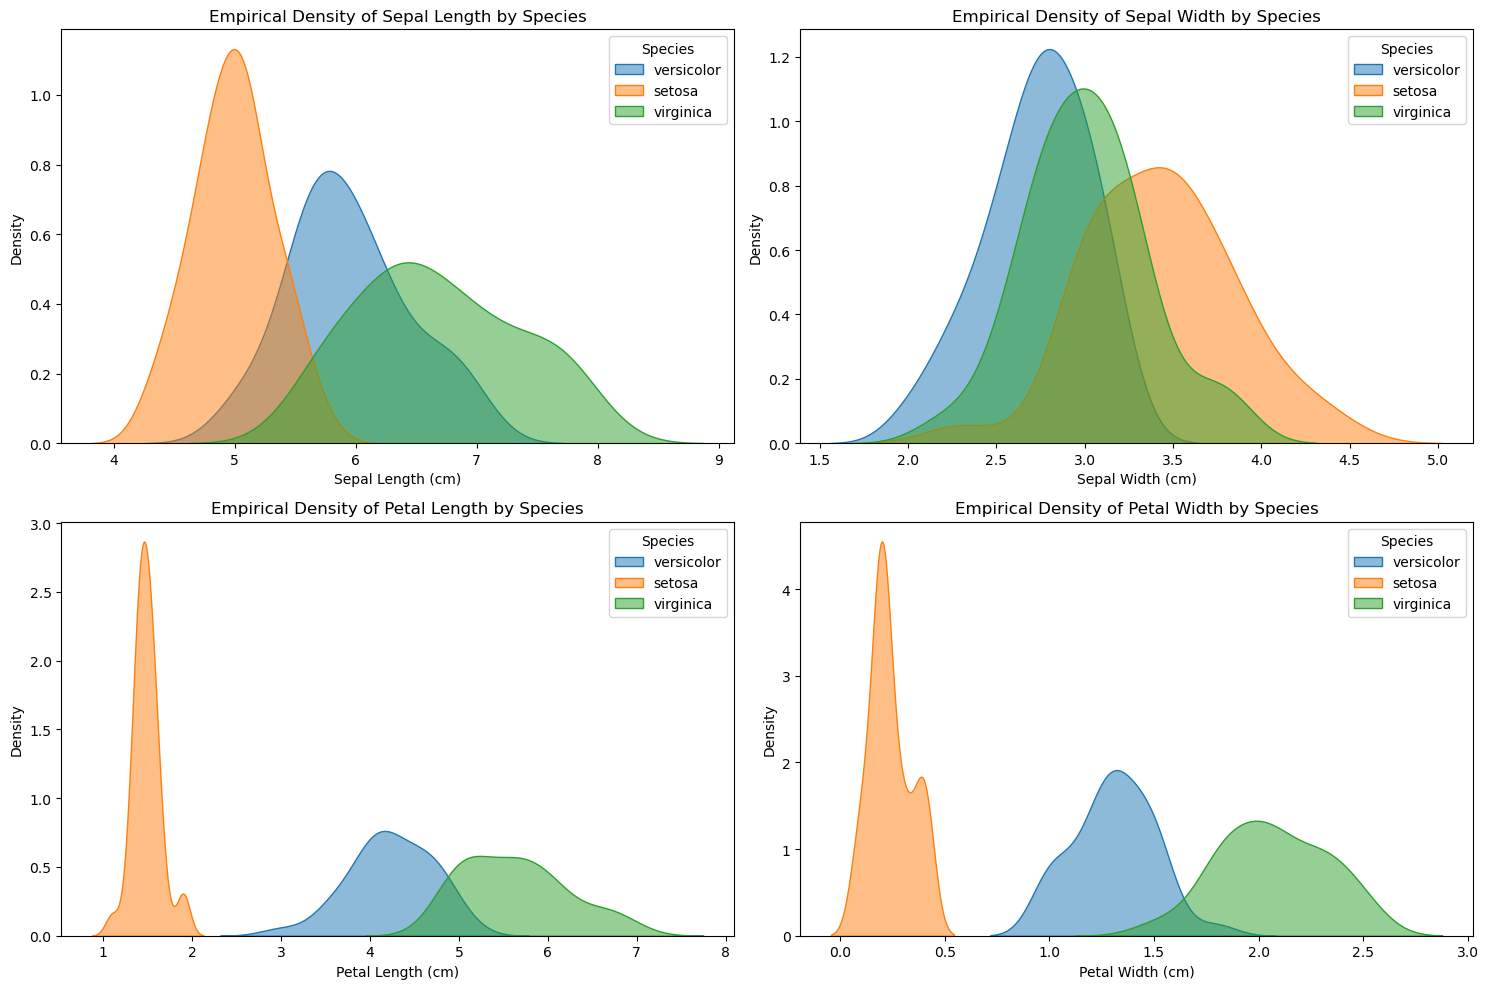

In [163]:
# Define the variable names and their titles for plotting
variables = ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']
titles = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

# Plot empirical density for each variable by species
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, var, title in zip(axs.flatten(), variables, titles):
    for species in train_data['Species'].unique():
        subset = train_data[train_data['Species'] == species]
        sns.kdeplot(subset[var], ax=ax, label=species, fill=True, alpha=0.5)
    ax.set_title(f'Empirical Density of {title} by Species')
    ax.set_xlabel(f'{title} (cm)')
    ax.set_ylabel('Density')
    ax.legend(title='Species')

plt.tight_layout()
plt.show()

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import pandas as pd

X = iris_df.drop('Species', axis=1)
y = iris_df['Species']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

iris_to_classify = [[6.56, 3.18, 4.31, 1.32]]
predicted_species = gnb.predict(iris_to_classify)
print("Predicted species for the given iris measurements:",
      predicted_species[0])

y_pred = gnb.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred, labels=gnb.classes_)
conf_matrix_df = pd.DataFrame(
    conf_matrix, index=gnb.classes_, columns=gnb.classes_)

print("Confusion Matrix for the Test Set:")
print(conf_matrix_df)

Predicted species for the given iris measurements: versicolor
Confusion Matrix for the Test Set:
            setosa  versicolor  virginica
setosa          15           0          0
versicolor       0          14          1
virginica        0           3         12


/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [144]:
predictions_df = pd.DataFrame({'Predicted Species': y_pred}, index=X_test.index)
predictions_df.head()

,Predicted Species
107,virginica
63,versicolor
133,versicolor
56,versicolor
127,virginica


In [166]:
from sklearn.metrics import accuracy_score

# Assuming y_test contains the true species labels and y_pred contains the predicted species labels from the test set
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of the Gaussian Naive Bayes classifier:", accuracy)

Accuracy of the Gaussian Naive Bayes classifier: 0.9111111111111111


In [108]:
# ------ END OF QUESTION 3 ----

In [167]:
# --- START OF Q4 ----

#q1
spam_data = pd.read_csv('/Users/giovannimaya/Downloads/spam.csv', encoding="latin-1")
spam_data = spam_data.rename(columns={'v1': 'Category', 'v2': 'Message'})
spam_data = spam_data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
spam_data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [199]:
## q2 

ham = spam_data[spam_data['Category'] == 'ham']
spam = spam_data[spam_data['Category'] == 'spam']
ham

,Category,Message,tokens,token_count
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point,, crazy.., Available...",20
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar..., Joking, wif, u, oni...]",6
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, so, early, hor..., U, c, already...",11
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, don't, think, he, goes, to, usf,, he,...",13
6,ham,Even my brother is not like to speak with me. ...,"[Even, my, brother, is, not, like, to, speak, ...",16
...,...,...,...,...
5565,ham,Huh y lei...,"[Huh, y, lei...]",3
5568,ham,Will Ì_ b going to esplanade fr home?,"[Will, Ì_, b, going, to, esplanade, fr, home?]",8
5569,ham,"Pity, * was in mood for that. So...any other s...","[Pity,, *, was, in, mood, for, that., So...any...",10
5570,ham,The guy did some bitching but I acted like i'd...,"[The, guy, did, some, bitching, but, I, acted,...",26


In [200]:
# q3
ham_text = ham['Message'].str.cat(sep=' ').split()
spam_text = spam['Message'].str.cat(sep=' ').split()
ham_text, spam_text

(['Go',
  'until',
  'jurong',
  'point,',
  'crazy..',
  'Available',
  'only',
  'in',
  'bugis',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet...',
  'Cine',
  'there',
  'got',
  'amore',
  'wat...',
  'Ok',
  'lar...',
  'Joking',
  'wif',
  'u',
  'oni...',
  'U',
  'dun',
  'say',
  'so',
  'early',
  'hor...',
  'U',
  'c',
  'already',
  'then',
  'say...',
  'Nah',
  'I',
  "don't",
  'think',
  'he',
  'goes',
  'to',
  'usf,',
  'he',
  'lives',
  'around',
  'here',
  'though',
  'Even',
  'my',
  'brother',
  'is',
  'not',
  'like',
  'to',
  'speak',
  'with',
  'me.',
  'They',
  'treat',
  'me',
  'like',
  'aids',
  'patent.',
  'As',
  'per',
  'your',
  'request',
  "'Melle",
  'Melle',
  '(Oru',
  'Minnaminunginte',
  'Nurungu',
  "Vettam)'",
  'has',
  'been',
  'set',
  'as',
  'your',
  'callertune',
  'for',
  'all',
  'Callers.',
  'Press',
  '*9',
  'to',
  'copy',
  'your',
  'friends',
  'Callertune',
  "I'm",
  'gonna',
  'be',
  'home',
  'soon',

In [202]:
from nltk.probability import FreqDist

freq_ham = FreqDist(ham_text)
freq_spam = FreqDist(spam_text)
spam_token_count = len(freq_spam)
ham_token_count = len(freq_ham)
sorry_spam_prob = freq_spam['Sorry'] / \
    sum(freq_spam.values()) if 'Sorry' in freq_spam else 0
sorry_ham_prob = freq_ham['Sorry'] / \
    sum(freq_ham.values()) if 'Sorry' in freq_ham else 0
freq_ham['Sorry'], freq_spam['Sorry']

(51, 1)

In [204]:
def calculate_message_probability(message, freq_dist):   
    vocab_size = len(set(spam_text + ham_text))
    message_tokens = message.split()
    message_probability = 1
    total_token_count = sum(freq_dist.values())

    for token in message_tokens:
        token_probability = (
            freq_dist[token] + 1) / (total_token_count + 1 * vocab_size)
        message_probability *= token_probability

    return message_probability


example_message = "Sorry my roommates took forever, it ok if I come by now?"
prob_message_ham = calculate_message_probability(
    example_message, freq_ham)
prob_message_spam = calculate_message_probability(
    example_message, freq_spam)

prob_message_ham, prob_message_spam

(1.6253944875477628e-37, 2.6732311299633616e-47)

In [210]:
from math import log


def calculate_log_odds(message, freq_dist, total_token_count, vocab_size, alpha=1):
    message_tokens = message.split()
    log_odds = 0

    for token in message_tokens:
        token_probability = (
            freq_dist[token] + alpha) / (total_token_count + alpha * vocab_size)
        log_odds += log(token_probability)

    return log_odds


vocab_size = len(set(spam_text + ham_text))
total_spam_tokens = sum(freq_spam.values())
total_ham_tokens = sum(freq_ham.values())

example_message = "Sorry my roommates took forever, it ok if I come by now?"
log_odds_ham = calculate_log_odds(
    example_message, freq_ham, total_ham_tokens, vocab_size)
log_odds_spam = calculate_log_odds(
    example_message, freq_spam, total_spam_tokens, vocab_size)

log_odds_ham, log_odds_spam

(-84.70989789289195, -107.23821146892767)

In [211]:
def score_message(message, ham_freq_dist, spam_freq_dist, total_ham_tokens, total_spam_tokens, vocab_size, alpha=1):
    log_odds_ham = calculate_log_odds(
        message, ham_freq_dist, total_ham_tokens, vocab_size, alpha)
    log_odds_spam = calculate_log_odds(
        message, spam_freq_dist, total_spam_tokens, vocab_size, alpha)

    return log_odds_ham - log_odds_spam


message_score = score_message(example_message, freq_ham,
                              freq_spam, total_ham_tokens, total_spam_tokens, vocab_size)

message_score

22.52831357603573

/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_42336/1613020830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['score'] = filtered_data.apply(lambda row: score_message(


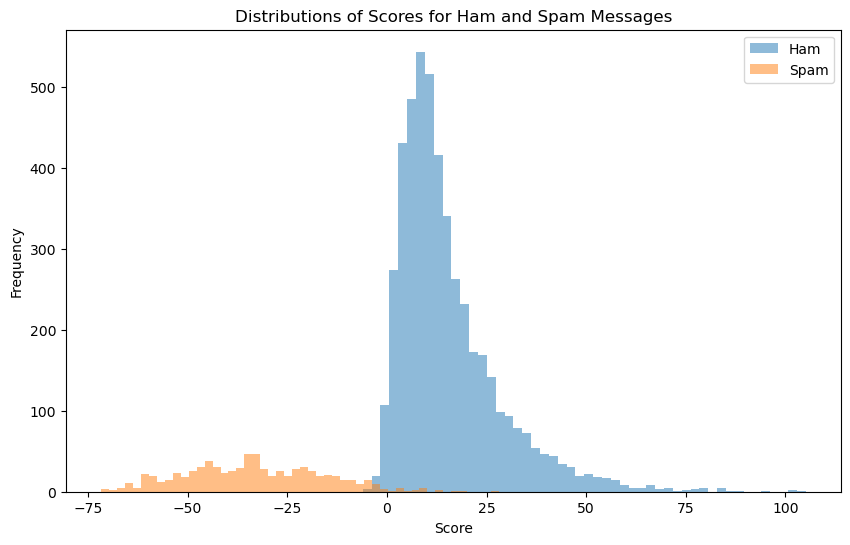

In [219]:
spam_data['tokens'] = spam_data['Message'].apply(lambda x: x.split())
spam_data['token_count'] = spam_data['tokens'].apply(len)
filtered_data = spam_data[spam_data['token_count'] < 75]
filtered_data['score'] = filtered_data.apply(lambda row: score_message(
    row['Message'], freq_ham, freq_spam, total_ham_tokens, total_spam_tokens, vocab_size), axis=1)

ham_scores = filtered_data[filtered_data['Category'] == 'ham']['score']
spam_scores = filtered_data[filtered_data['Category'] == 'spam']['score']

plt.figure(figsize=(10, 6))
plt.hist(ham_scores, bins=50, alpha=0.5, label='Ham')
plt.hist(spam_scores, bins=50, alpha=0.5, label='Spam')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distributions of Scores for Ham and Spam Messages')
plt.savefig('foo.png', bbox_inches='tight')

In [221]:
filtered_data['predicted'] = filtered_data['score'].apply(
    lambda x: 'ham' if x > 1 else 'spam')

conf_matrix = confusion_matrix(
    filtered_data['Category'], filtered_data['predicted'], labels=['ham', 'spam'])
tn, fp, fn, tp = conf_matrix.ravel()

# Calculating accuracy, sensitivity (recall or true positive rate), and specificity (true negative rate)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

conf_matrix, accuracy, sensitivity, specificity

/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_42336/1063536260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['predicted'] = filtered_data['score'].apply(


(array([[4649,  160],
        [  18,  729]]),
 0.9679625629949604,
 0.9759036144578314,
 0.9667290496984821)

In [215]:
def evaluate_performance_with_penalty(alpha):
    filtered_data[f'score_alpha_{alpha}'] = filtered_data.apply(
        lambda row: score_message(row['Message'], freq_ham, freq_spam,
                                  total_ham_tokens, total_spam_tokens, vocab_size, alpha),
        axis=1
    )
    filtered_data[f'predicted_alpha_{alpha}'] = filtered_data[f'score_alpha_{alpha}'].apply(
        lambda x: 'ham' if x > 1 else 'spam')
    conf_matrix = confusion_matrix(
        filtered_data['Category'], filtered_data[f'predicted_alpha_{alpha}'], labels=['ham', 'spam'])
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return accuracy, sensitivity, specificity


performance_alpha_0_5 = evaluate_performance_with_penalty(0.5)
performance_alpha_2 = evaluate_performance_with_penalty(2)

performance_alpha_0_5, performance_alpha_2

/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_42336/2637853742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f'score_alpha_{alpha}'] = filtered_data.apply(
/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_42336/2637853742.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f'predicted_alpha_{alpha}'] = filtered_data[f'score_alpha_{alpha}'].apply(
/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_42336/2637853742.py:2: SettingWithCopyWarning: 

((0.9778617710583153, 0.9852744310575636, 0.9767103347889374),
 (0.9600431965442765, 0.9598393574297188, 0.9600748596381784))